In [9]:
## modified with ALL-IDB dataset
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = './tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (257, 257, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 257, 257, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 128, 128, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 128, 128, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 128, 128, 32) 0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [10]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

"""
local_zip = './tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('./tmp')
zip_ref.close()
"""

# Define our example directories and files
base_dir = './tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train-wb')
validation_dir = os.path.join( base_dir, 'validation-wb')


train_cats_dir = os.path.join(train_dir, 'blast') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'nonblast') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'blast') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'nonblast')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 9,
                                                    class_mode = 'binary', 
                                                    target_size = (257, 257))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 9,
                                                          class_mode  = 'binary', 
                                                          target_size = (257, 257))

Found 198 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [18]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 9,
            epochs = 20,
            validation_steps = 3,
            verbose = 2)

Epoch 1/20
9/9 - 14s - loss: 2.4697 - accuracy: 0.5556 - val_loss: 1.3494 - val_accuracy: 0.5556
Epoch 2/20
9/9 - 13s - loss: 1.4524 - accuracy: 0.5556 - val_loss: 0.6368 - val_accuracy: 0.7037
Epoch 3/20
9/9 - 13s - loss: 1.1391 - accuracy: 0.5432 - val_loss: 0.4065 - val_accuracy: 0.7778
Epoch 4/20
9/9 - 13s - loss: 0.4210 - accuracy: 0.8148 - val_loss: 0.6743 - val_accuracy: 0.7037
Epoch 5/20
9/9 - 14s - loss: 0.6936 - accuracy: 0.7654 - val_loss: 0.7477 - val_accuracy: 0.6296
Epoch 6/20
9/9 - 13s - loss: 0.5587 - accuracy: 0.7531 - val_loss: 0.5664 - val_accuracy: 0.7778
Epoch 7/20
9/9 - 13s - loss: 0.4072 - accuracy: 0.8272 - val_loss: 0.6956 - val_accuracy: 0.6296
Epoch 8/20
9/9 - 13s - loss: 0.4441 - accuracy: 0.8395 - val_loss: 0.3866 - val_accuracy: 0.8148
Epoch 9/20
9/9 - 13s - loss: 0.7655 - accuracy: 0.7160 - val_loss: 0.7092 - val_accuracy: 0.6296
Epoch 10/20
9/9 - 13s - loss: 0.4819 - accuracy: 0.8025 - val_loss: 2.1020 - val_accuracy: 0.4815
Epoch 11/20
9/9 - 13s - loss:

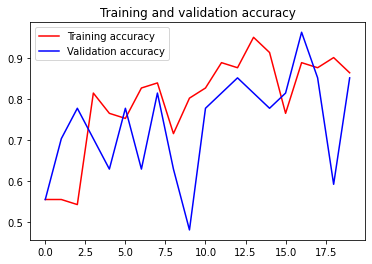

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()